In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
import warnings 
warnings.filterwarnings("ignore")
NUM_TRIALS = 1000
SEED = 42420
scv = StratifiedKFold(n_splits=5)

In [2]:
df = pd.read_csv('Crop_Location_Data_20221201.csv')
s1_data = np.load('sar_data.npy') #Sentinel-2 data
s2_data = np.load('sentinel2_data_train.npy')[:,:4,:]

In [3]:
def prep_s2_data(data):
    data[data == 0] = np.nan
    red = data[:,0,:]
    nir = data[:,3,:]
    ndvi_mean_clean = (nir-red)/(nir+red)
    ndvi = pd.DataFrame(ndvi_mean_clean)
    return ndvi

def prep_s1_data(data):
    vv = data[:,0,:]
    vh = data[:,1,:]
    q = vh/vv
    n = q*(q+3)
    d = (q+1)**2
    rvi = n/d #CALCULATION OF Radar Vegetation Index
    if len(data.shape) == 3:
        rvi = rvi.reshape(data.shape[0],1,data.shape[2])
    else:
        rvi = rvi.reshape(data.shape[0],1)
    rvi = np.nan_to_num(rvi, nan=0)
    new_data = np.concatenate((data,rvi),axis=1).copy()
    return new_data

proc_pipe = Pipeline([
      ('scale', MinMaxScaler()), #Scale the data
      ('thresh', VarianceThreshold()), #Remove colmns with constant features
      ('select_feats', SelectKBest(f_classif, k=50)) #select top 50 features using f_classif strategy
])

def create_col_names(features=['VV','VH','RVI'],timesteps=52):
    cols = [f'{feat}_{t}' for feat in features for t in range(0,timesteps)]
    dicts = {t:c for t,c in zip(range(0,len(features)*timesteps),cols)}
    return dicts

def proc_pipeline(s1data,s2data):
    data_s1 = s1data[:,:,:52].copy()
    data_s1 = prep_s1_data(data_s1)
    data_s1 = pd.DataFrame(data_s1.reshape(data_s1.shape[0],data_s1.shape[1]*data_s1.shape[2]))
    if s2data is not None:
        data_s2 = prep_s2_data(s2data)
        complete_df = pd.concat([data_s1,data_s2],axis=1, ignore_index=True)
        return complete_df
    else:
        return data_s1

In [4]:
complete_df = proc_pipeline(s1_data, None)
dicts = create_col_names()
complete_df.rename(columns=dicts,inplace=True)

In [5]:
complete_df

,VV_0,VV_1,VV_2,VV_3,VV_4,VV_5,VV_6,VV_7,VV_8,VV_9,...,RVI_42,RVI_43,RVI_44,RVI_45,RVI_46,RVI_47,RVI_48,RVI_49,RVI_50,RVI_51
0,0.039149,0.034205,0.044161,0.029956,0.032765,0.026254,0.075706,0.084049,0.041761,0.026061,...,1.109153,1.120790,1.110529,1.104947,1.110555,1.115490,1.088580,1.094324,1.053526,1.064133
1,0.026118,0.036568,0.041516,0.030507,0.064327,0.026621,0.094764,0.021684,0.017601,0.005918,...,1.123149,1.124229,1.123904,1.109489,1.124946,1.096108,1.101996,1.124556,1.043715,1.021130
2,0.044205,0.031559,0.039120,0.018742,0.043604,0.026554,0.058810,0.076552,0.038845,0.017549,...,1.114845,1.119457,1.117225,1.112082,1.118335,1.118586,1.122740,1.118968,1.034430,1.035563
3,0.041290,0.032280,0.042852,0.038250,0.044909,0.034352,0.053895,0.052763,0.046522,0.022569,...,1.124986,1.124999,1.111018,1.097056,1.107514,1.059901,1.099912,1.113194,1.080739,1.032652
4,0.022037,0.028693,0.036434,0.033285,0.085088,0.041033,0.049838,0.008084,0.008059,0.006776,...,1.124550,1.117012,1.117879,1.116569,1.124795,1.114218,1.110528,1.118907,1.034686,1.038039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.094441,0.099455,0.068456,0.089796,0.081265,0.057693,0.104882,0.119630,0.050866,0.095835,...,1.121684,1.110466,1.122813,1.123018,1.124222,1.112234,1.124525,1.119723,1.121672,1.114054
596,0.093986,0.114299,0.073228,0.104556,0.071013,0.053510,0.089211,0.069450,0.078184,0.109110,...,1.116106,1.110371,1.122510,1.120203,1.119964,1.124865,1.120409,1.124742,1.117305,1.120384
597,0.082631,0.099725,0.063362,0.078933,0.078904,0.067436,0.062394,0.063671,0.049033,0.099516,...,1.107018,1.120214,1.102492,1.121064,1.099339,1.124331,1.110506,1.124108,1.112376,1.107478
598,0.075545,0.095171,0.063125,0.097325,0.097000,0.068528,0.059935,0.081552,0.066601,0.072443,...,1.121916,1.115790,1.119424,1.119727,1.122595,1.124803,1.114920,1.119903,1.124957,1.117045


In [6]:
le = LabelEncoder()
y = le.fit_transform(df['Class of Land'])
X = proc_pipe.fit_transform(complete_df,y)
X.shape

(600, 50)

In [7]:
sel_feats = proc_pipe.get_feature_names_out().tolist()

In [8]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.45,shuffle=True, random_state=807410395)
X_train.shape, y_train.sum()

((330, 50), 165)

In [9]:
clf = LogisticRegression(max_iter=5000)
scv = StratifiedKFold(n_splits=5)
cross_val_score(clf, X_train, y_train, cv=scv.split(X_train, y_train), scoring='accuracy').mean()

0.9878787878787879

In [10]:
model = clf.fit(X,y)
coefs = model.coef_.tolist()[0]
feat_imp = {c:i for c,i in zip(sel_feats,[abs(c) for c in coefs])}

In [11]:
import plotly.graph_objects as go
# Sorting feature importance dictionary by values
sorted_features = sorted(feat_imp.items(), key=lambda x: x[1], reverse=True)

# Extracting feature names and importance scores
features = [item[0] for item in sorted_features]
importance_scores = [item[1] for item in sorted_features]

# Creating a bar plot
fig = go.Figure(data=[go.Bar(x=features, y=importance_scores)])

# Adding title and labels
fig.update_layout(title='Feature Importance', xaxis_title='Feature', yaxis_title='Importance Score')

# Show plot
fig.show()

In [12]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [13]:
import plotly.graph_objects as go

# Create a list to store data traces
traces = []

# Create a violin plot for each feature variable
for feature_name, feature_values in complete_df[sel_feats].items():
    trace = go.Violin(y=feature_values, x=y, name=feature_name, box_visible=True, meanline_visible=True)
    traces.append(trace)

# Create the figure
fig = go.Figure(data=traces)

# Update layout
fig.update_layout(title='Violin Plot of Feature Variables by Target Class', yaxis_title='Feature Value', xaxis_title='Target Class')

# Show plot
fig.show()


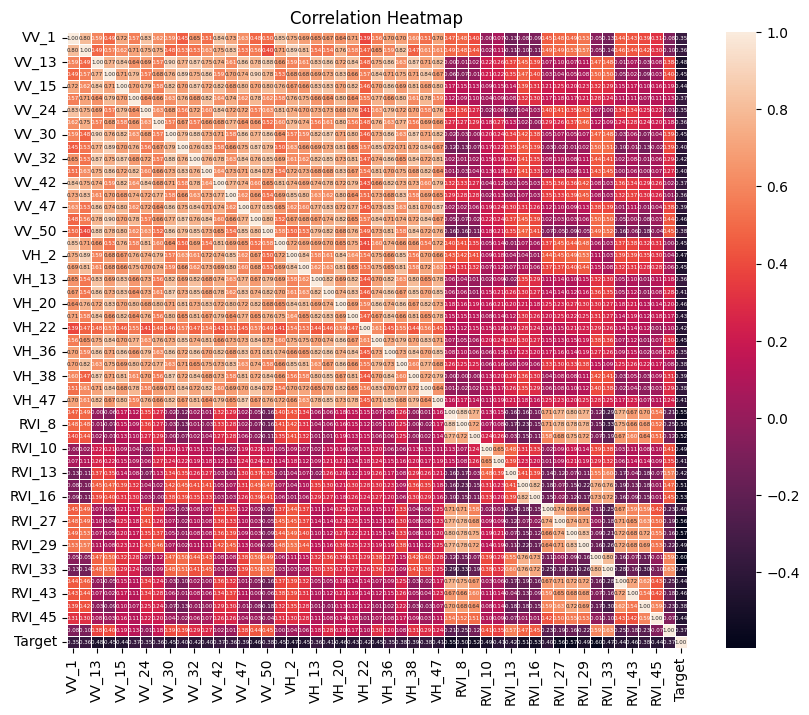

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_plot(dataframe):
    """
    Generates a correlation heatmap plot using Seaborn.

    Parameters:
    - dataframe: pandas DataFrame containing numeric columns.

    Returns:
    - None (displays the plot).
    """
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()

    # Generate a heatmap using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, annot_kws={"size": 4})
    plt.title('Correlation Heatmap')
    plt.show()

# Example usage:
# Replace 'df' with your DataFrame containing numeric columns
df = complete_df[sel_feats].copy()
df['Target'] = y.tolist()
correlation_plot(df)

In [45]:
from sklearn.manifold import TSNE
import plotly.express as px

def tsne_plot(dataframe, target_column):
    """
    Generates a t-SNE plot using Plotly with hover information to visualize high-dimensional data.

    Parameters:
    - dataframe: pandas DataFrame containing numeric columns.
    - target_column: Name of the target column in the DataFrame.

    Returns:
    - fig: Plotly Figure object containing the t-SNE plot with hover information.
    """
    # Extract features and target variable
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]

    # Initialize t-SNE object
    tsne = TSNE(n_components=2, random_state=42, perplexity=40)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X)

    # Create Plotly scatter plot with hover information
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y, labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'}, color_continuous_scale='viridis', title='t-SNE Plot')
    fig.update_coloraxes(colorbar_title=target_column)
    fig.update_traces(hoverinfo='text', text=dataframe.index.to_list())

    return fig, X_tsne

def tsne_plot(dataframe, target_column):
    """
    Generates a t-SNE plot using Plotly with hover information to visualize high-dimensional data.

    Parameters:
    - dataframe: pandas DataFrame containing numeric columns.
    - target_column: Name of the target column in the DataFrame.

    Returns:
    - fig: Plotly Figure object containing the t-SNE plot with hover information.
    """
    # Extract features and target variable
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]

    # Initialize t-SNE object
    tsne = TSNE(n_components=2, random_state=42)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X)

    # Create hover text with sample indices
    hover_text = ['Index: {}'.format(index) for index in dataframe.index]

    # Create Plotly scatter plot with hover information
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y, labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'}, color_continuous_scale='viridis', title='t-SNE Plot', hover_name=hover_text)
    fig.update_coloraxes(colorbar_title=target_column)

    return fig, X_tsne

# Example usage:
# Replace 'df' with your DataFrame and 'target_column' with the name of your target column
fig, tsne = tsne_plot(df, 'Target')

fig.show()


In [56]:
train = df.iloc[[406,234],:].rese
test = df.iloc[[403,112],:]

In [57]:
df.drop([406,234,403,112])

,VV_1,VV_2,VV_13,VV_14,VV_15,VV_16,VV_24,VV_29,VV_30,VV_31,...,RVI_28,RVI_29,RVI_32,RVI_33,RVI_42,RVI_43,RVI_44,RVI_45,RVI_50,Target
0,0.034205,0.044161,0.006129,0.006217,0.011731,0.018375,0.032007,0.019112,0.017257,0.018096,...,1.124429,1.120293,1.024871,1.033920,1.109153,1.120790,1.110529,1.104947,1.053526,1
1,0.036568,0.041516,0.005210,0.004159,0.035587,0.038658,0.049165,0.009479,0.003606,0.006841,...,1.091534,1.100157,1.030490,1.047232,1.123149,1.124229,1.123904,1.109489,1.043715,1
2,0.031559,0.039120,0.007256,0.003802,0.032124,0.030044,0.036283,0.006359,0.007777,0.008904,...,1.122468,1.124340,1.027990,1.054569,1.114845,1.119457,1.117225,1.112082,1.034430,1
3,0.032280,0.042852,0.008179,0.010770,0.006533,0.004156,0.040713,0.047700,0.006055,0.008673,...,1.124357,1.112858,1.033046,1.032089,1.124986,1.124999,1.111018,1.097056,1.080739,1
4,0.028693,0.036434,0.005805,0.004665,0.011392,0.019559,0.025255,0.031457,0.010184,0.014683,...,1.122216,1.123358,1.030796,1.037641,1.124550,1.117012,1.117879,1.116569,1.034686,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.099455,0.068456,0.068343,0.037711,0.069391,0.037763,0.078458,0.054900,0.115230,0.049873,...,1.113528,1.115611,1.110344,1.121941,1.121684,1.110466,1.122813,1.123018,1.121672,0
596,0.114299,0.073228,0.057811,0.076574,0.080363,0.055754,0.079771,0.055769,0.087369,0.124036,...,1.125000,1.117599,1.121730,1.121287,1.116106,1.110371,1.122510,1.120203,1.117305,0
597,0.099725,0.063362,0.080103,0.081095,0.045270,0.053149,0.066734,0.045956,0.047289,0.067957,...,1.122518,1.105074,1.118917,1.118996,1.107018,1.120214,1.102492,1.121064,1.112376,0
598,0.095171,0.063125,0.063449,0.074882,0.072464,0.061694,0.062306,0.070260,0.078438,0.078144,...,1.119915,1.123067,1.124443,1.123133,1.121916,1.115790,1.119424,1.119727,1.124957,0


In [70]:
y_train.append(train['Target'], index=[len(y_train)])

AttributeError: 'Series' object has no attribute 'append'

In [66]:
train['Target']

406    0
234    1
Name: Target, dtype: int64

In [60]:
X = df.drop(['Target'],axis=1)
y = df['Target']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.45,shuffle=True, random_state=807410395)
X_train = X_train.merge(train.drop(['Target'],axis=1))
y_train = y_train.merge(train['Target'],axis=1)
X_test = X_test.merge(test.drop(['Target'],axis=1))
y_test = y_test.merge(test['Target'],axis=1)
X_train.shape, y_train.sum()

AttributeError: 'Series' object has no attribute 'merge'

,VV_1,VV_2,VV_13,VV_14,VV_15,VV_16,VV_24,VV_29,VV_30,VV_31,...,RVI_27,RVI_28,RVI_29,RVI_32,RVI_33,RVI_42,RVI_43,RVI_44,RVI_45,RVI_50
335,0.078236,0.040075,0.087893,0.031091,0.094726,0.040005,0.067376,0.030603,0.100476,0.052325,...,1.114443,1.110693,1.099570,1.120682,1.122159,1.120204,1.121392,1.121114,1.098864,1.096702
214,0.009329,0.010061,0.029764,0.029805,0.023534,0.029477,0.036955,0.009311,0.046153,0.048807,...,1.050911,1.059122,1.077785,1.122034,1.106035,1.085855,1.107554,1.048444,1.071159,1.115052
546,0.005177,0.006335,0.005114,0.005030,0.004715,0.006177,0.006232,0.005958,0.004693,0.006349,...,1.122164,1.122784,1.088312,1.124997,1.078484,1.122185,1.088597,1.124718,1.107390,1.098503
529,0.006986,0.006148,0.004938,0.004674,0.006944,0.006340,0.006640,0.005448,0.005250,0.005715,...,1.124274,1.117060,1.088291,1.124973,1.118408,1.120439,1.119526,1.118258,1.122140,1.124997
176,0.004726,0.003857,0.039224,0.029195,0.024134,0.022608,0.020550,0.012513,0.028575,0.030753,...,1.058357,1.046407,1.029295,1.064330,1.122189,1.056330,1.052244,1.035369,1.026007,1.124999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.013252,0.011223,0.026015,0.019378,0.026815,0.027284,0.037996,0.012858,0.046417,0.032551,...,1.100602,1.050360,1.038887,1.085438,1.077342,1.089935,1.055555,1.058557,1.044515,1.119749
147,0.027856,0.052156,0.010080,0.008407,0.007076,0.005854,0.037122,0.045231,0.013161,0.009363,...,1.097965,1.117131,1.118518,1.031898,1.050110,1.124252,1.115940,1.120238,1.102805,1.048519
361,0.051234,0.073109,0.104136,0.051197,0.074707,0.064856,0.078194,0.073405,0.061552,0.080296,...,1.120793,1.125000,1.124547,1.118717,1.114085,1.114904,1.094602,1.122685,1.123678,1.124930
561,0.080064,0.044684,0.073207,0.042783,0.058211,0.061878,0.055358,0.072470,0.076846,0.087567,...,1.101743,1.124728,1.117568,1.123910,1.123463,1.100000,1.124318,1.110296,1.119628,1.112832


<Axes: >

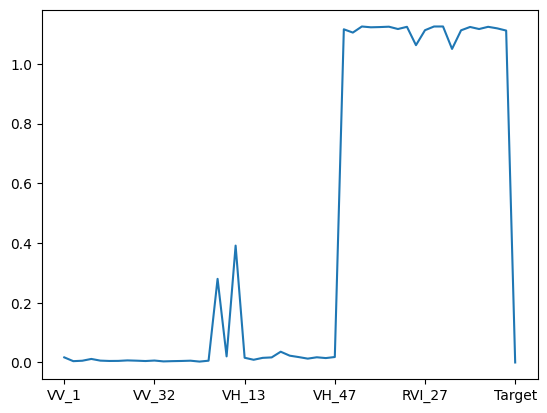

In [51]:
#406, 403, 234, 112
df.iloc[406].plot()


In [8]:
#NESTED CV STRATEGY TO SCORE THE VALIDATION SET
def nested_cv(
    pipe,
    X,
    y,
    grid,
    splits,
    iters=5,
    seed=42,
    metrics="accuracy",
):
    inner_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    outer_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    clf = RandomizedSearchCV(estimator=pipe, n_iter=iters, param_distributions=grid, cv=inner_cv, 
                            scoring=metrics, n_jobs=-1, random_state=SEED)
    scores = cross_validate(clf, X=X, y=y, cv=outer_cv, scoring=metrics, return_estimator=True)
    model_params = [e.best_estimator_ for e in scores["estimator"]]
    return {
        "model_params": model_params,
        "accuracy": scores["test_score"],
    }

#FUNCTION TO RUN MULTIPLE NESTED CV TRIALS
def run_cvs(pipe, X, y, grid, splits=10, iters=5, metrics = 'accuracy'):
    cv_results = pd.DataFrame()
    row_res = {}

    for i in tqdm(range(NUM_TRIALS)): #ITERATE THROUGH NUMBER OF TRIALS
        row_res["seed"] = i
        cv_res = nested_cv(pipe, X, y, grid=grid, splits=splits, iters=iters, seed=i, metrics=metrics)
        row_res.update(cv_res)
        temp_res = pd.DataFrame(row_res, columns=list(row_res.keys()))
        cv_results = pd.concat([cv_results, temp_res], axis=0, ignore_index=True)
        row_res = {}
    return cv_results

#FUNCTION TO FIND THE WORST PERFORMING TRIAL OUT OF ALL THE TRIALS
def find_worst_seeds(res, topk=5):
    seeds = []
    for seed in res.groupby('seed')['accuracy'].mean().sort_values(ascending=True).index[0:topk].values:
        seeds.append(seed)
    return seeds

In [9]:
#BLOCK TO FIND THE WORST PERFORMING SEED ON THE DATA
# lr_params = {
#     "fit_intercept": [True, False],
#     "C": np.linspace(0.01, 0.5, 40, dtype=np.float32),
#     # "l1": np.linspace(0.1, 1.0, 40, dtype=np.float32),
#     "solver": ["lbfgs"],
#     "penalty": ["l2"],
# }
# clf = LogisticRegression(max_iter=200,random_state=420)
# res_ridge = run_cvs(clf, X_train, y_train, lr_params, splits=5, iters=1, metrics='f1_weighted')
# seeds = find_worst_seeds(res_ridge, topk=10)

In [10]:
seeds = [431]#[431, 240, 139, 22, 364, 295, 589, 720, 85, 495]

In [11]:
#MAKING VOTING CLASSIFIER USING A LIST OF MODELS
def make_vc(search_list, name_list):
    estimator_list = [(str(n), s) for n,s in zip(name_list, search_list)]
    return VotingClassifier(estimators=estimator_list, voting='soft')

def evaluate(clf):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(classification_report(y_test,predictions))

def predict_submission(clf, use_s2=False):
    testdfs1 = np.load('sar_data_test.npy')
    if use_s2:
        testdfs2 = np.load('sentinel2_data_test.npy')
        proc_testdf = proc_pipeline(testdfs1,testdfs2)
    else:
        proc_testdf = proc_pipeline(testdfs1,None)
    X_sub = proc_pipe.transform(proc_testdf)
    clf.fit(X,y)
    submission_predictions = clf.predict(X_sub)
    submission_probs = clf.predict_proba(X_sub)
    return submission_predictions, submission_probs

#THE FUNCTION TO CREATE VOTING CLASSIFIER BASED ON PERFORMANCE ON WORST PERFORMING SEED
def score_worst_seeds(clf, params, X, y, seeds, iters=100):
    model_ls = []
    valid_scores = []

    for seed in tqdm(seeds):
        cv_res = nested_cv(clf, X, y, grid=params, splits=5, iters=iters, seed=seed, metrics='f1_weighted')
        cv_models = cv_res['model_params']
        model = make_vc(cv_models, list([i for i in range(0,5)]))
        score = cv_res['accuracy'].mean()
        model_ls.append(model)
        valid_scores.append(score*100)

    print(f'The mean accuracy for the {len(seeds)} worst seeds is {np.mean(valid_scores)} and the std. dev. is {np.std(valid_scores)}')
    return make_vc(model_ls, seeds)

In [12]:
rf_params = {
    "n_estimators": np.linspace(50, 100, 5, dtype=np.int16),
    "max_depth": np.linspace(2, 10, 10, dtype=np.int16),
    "min_samples_split": np.linspace(2, 10, 10, dtype=np.int16),
    "min_samples_leaf": np.linspace(2, 10, 10, dtype=np.int16),
    "criterion": ["gini", "entropy", "log_loss"],
    "ccp_alpha": np.linspace(0.0, 5.0, 20, dtype=np.float16),
}
clf = RandomForestClassifier(random_state=420)
model_rf = score_worst_seeds(clf, rf_params, X_train, y_train, seeds)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:18<00:00, 18.83s/it]

The mean accuracy for the 1 worst seeds is 99.39380022962112 and the std. dev. is 0.0


In [13]:
svm_params = {
    "kernel": ['rbf'],
    "C": np.linspace(0.001, 2.0, 30, dtype=np.float32),
    "gamma": np.linspace(0.01, 3.0, 30, dtype=np.float16),
}
clf = SVC(random_state=420, probability=True)
model_svm = score_worst_seeds(clf, svm_params, X_train, y_train, seeds, iters=200)

100%|██████████| 1/1 [00:06<00:00,  6.77s/it]

The mean accuracy for the 1 worst seeds is 99.08902691511386 and the std. dev. is 0.0


### Create ensemble of random forest and svm

In [14]:
search_list = [model_rf,model_svm]
name_list = ['rf', 'svm']
vclf = make_vc(search_list, name_list)

### Measure performance on hold-out set

In [15]:
evaluate(vclf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00       135

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



### Prediction on submission data

In [16]:
submission = pd.read_csv('submission1.csv')
submission_predictions, _ = predict_submission(vclf, use_s2=False)
submission['target'] = submission_predictions.tolist()
submission.target = le.inverse_transform(submission.target)
submission.to_csv('submission_model.csv', index=False)